# Tree Cover from MODIS Data

Generate MODIS tree cover map for the US, lower 48 from the MOD44B dataset for 2016. The data for this work can be found in ADAPT under /css/modis/Collection6/L3/MOD44B-VCF/2016/065. Looks like there are a total of 291 files.

Requirements:
- All together in the native projection
- All together in lat-long projection (geographic)
- Tell me what you did, how and why, questions

Installation requirements: conda install GDAL, pip install rasterio --force-reinstall --no-binary rasterio <br/>
Author: Jordan A. Caraballo-Vega <jorda.a.caraballo-vega@nasa.gov> <br/>
Version: 0.0.1

In [23]:
# Import libraries
import rasterio
import xarray as xr
import rioxarray as xrx
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Test filename to work with in the meantime
filename = '/Users/jacaraba/Desktop/development/ilab/nccs-remote-sensing-work/data/MOD44B.A2016065.h14v10.006.2017081141243.hdf'

In [25]:
# Read single file for now
modis_data = xrx.open_rasterio(filename)

## Open MODIS dataset with GDAL and XARRAY

In the Collection 6 release of the MODIS VCF product (MOD44B) there are 7 science data sets (SDSs): 1) percent tree cover; 2) percent non-tree vegetation; 3) percent non-vegetated; 4) quality; 5) percent tree cover standard deviation (SD); 6) percent non-vegetated standard deviation (SD); and 7) cloud. The first three layers listed are the primary data layers with the remaining 4 layers providing the user with indications of the overall quality of the data for any
given pixel.

In [26]:
modis_template_layers = 'HDF4_EOS:EOS_GRID:"%s":MOD44B_250m_GRID:%s'  # template from MODIS product
modis_selected_layers = ['Percent_Tree_Cover']  # modis layers to utilize
lat_long_projection = "EPSG:4326"

In [29]:
tree_cover = modis_data['Percent_Tree_Cover']
print(tree_cover.min().values, tree_cover.max().values, tree_cover.shape)

0 200 (1, 4800, 4800)


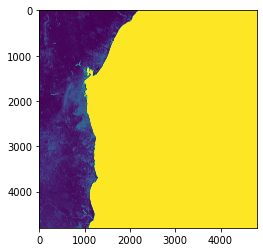

In [28]:
plt.imshow(np.squeeze(tree_cover.values))
plt.show()

In [ ]:
# reproject and output file
tree_cover.rio.reproject(lat_long_projection).rio.to_raster("modis_tree_cover_test.tif")